<a href="https://colab.research.google.com/github/angelrodriguez0617/CS-4710-Machine-Learning-II/blob/main/A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CS 4710 - Machine Learning II

## Assigment A8

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A sinusoidal-forecasting example



Generate own timeseries in the form of y(t) = A(t) * cos(wt) + noise

In [2]:
import numpy as np
import os

# Parameters for the time series
A = 1       # Amplitude, can be made a function of t for varying amplitude
w = 2*np.pi # Angular frequency, 2*pi for a 1-second period
end_time = 10
t = np.linspace(0, end_time, 10000) # Time vector from 0 to 10 seconds

# Generate the time series
y = A * np.cos(w * t) + np.random.normal(0, 0.4, len(t))

# Assign the generated time series to 'temperature'
temperature = y

# Create 'raw_data' with the same time series repeated for each 'feature'
# Assuming you want to simulate multiple features as in the original dataset
num_features = 1  # This is an example, set it to the number of features you need
raw_data = np.tile(temperature, (num_features, 1)).T

# Now you can continue with the rest of your code using 'temperature' and 'raw_data'


**Plotting the timeseries**

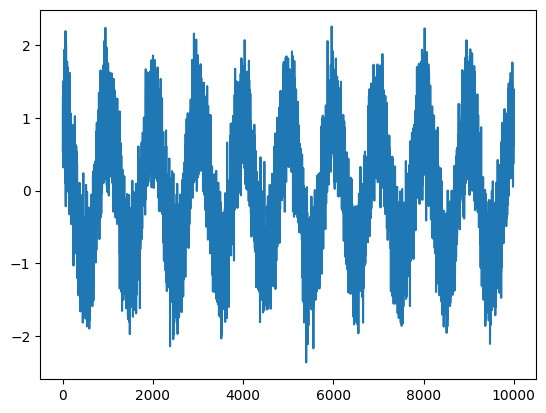

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 1000 points of the timeseries**

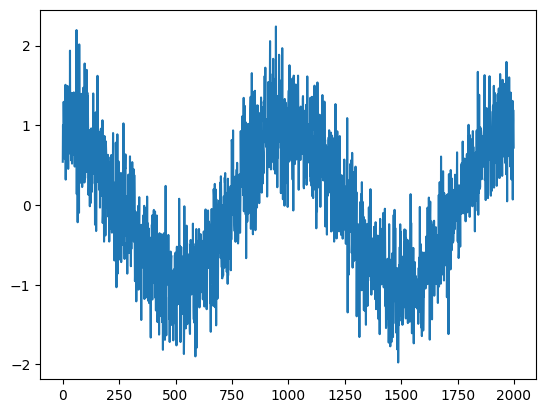

In [4]:
plt.plot(range(2000), temperature[:2000])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 5000
num_val_samples: 2500
num_test_samples: 2500


### Preparing the data

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 1)
targets shape: (256,)


## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/50
17/17 [==============================] - 11s 363ms/step - loss: 0.6513 - mae: 0.6846 - val_loss: 0.5890 - val_mae: 0.6485
Epoch 2/50
17/17 [==============================] - 5s 280ms/step - loss: 0.5503 - mae: 0.6248 - val_loss: 0.4750 - val_mae: 0.5740
Epoch 3/50
17/17 [==============================] - 6s 341ms/step - loss: 0.3294 - mae: 0.4634 - val_loss: 0.1737 - val_mae: 0.3369
Epoch 4/50
17/17 [==============================] - 5s 280ms/step - loss: 0.2392 - mae: 0.3918 - val_loss: 0.1874 - val_mae: 0.3501
Epoch 5/50
17/17 [==============================] - 6s 331ms/step - loss: 0.2366 - mae: 0.3874 - val_loss: 0.1677 - val_mae: 0.3295
Epoch 6/50
17/17 [==============================] - 5s 278ms/step - loss: 0.2301 - mae: 0.3821 - val_loss: 0.1700 - val_mae: 0.3317
Epoch 7/50
17/17 [==============================] - 5s 278ms/step - loss: 0.2220 - mae: 0.3767 - val_loss: 0.1690 - val_mae: 0.3314
Epoch 8/50
17/17 [==============================] - 6s 335ms/step - loss: 0

8/8 [==============================] - 0s 31ms/step


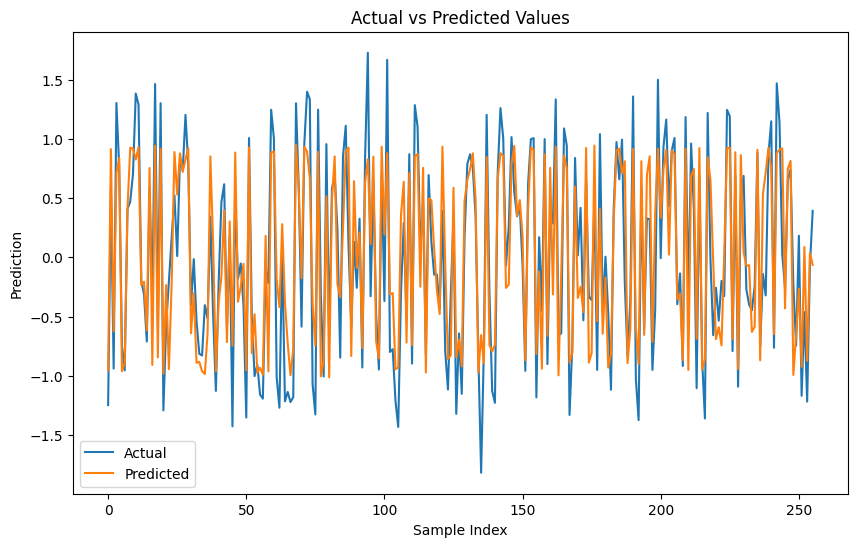

In [11]:
import matplotlib.pyplot as plt

# Assuming 'val_dataset' is a tuple of (inputs, targets)
for batch in val_dataset.take(1):  # Take a single batch from the validation dataset
    inputs, targets = batch

# Predict the output using the trained model
predicted = model.predict(inputs)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.legend()
plt.show()



In [12]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
17/17 [==============================] - 14s 611ms/step - loss: 0.5612 - mae: 0.6298 - val_loss: 0.5375 - val_mae: 0.6118
Epoch 2/50
17/17 [==============================] - 10s 584ms/step - loss: 0.5241 - mae: 0.6063 - val_loss: 0.5064 - val_mae: 0.5906
Epoch 3/50
17/17 [==============================] - 10s 576ms/step - loss: 0.4978 - mae: 0.5876 - val_loss: 0.4670 - val_mae: 0.5628
Epoch 4/50
17/17 [==============================] - 9s 523ms/step - loss: 0.4479 - mae: 0.5522 - val_loss: 0.3805 - val_mae: 0.4953
Epoch 5/50
17/17 [==============================] - 10s 576ms/step - loss: 0.3888 - mae: 0.5024 - val_loss: 0.2710 - val_mae: 0.4156
Epoch 6/50
17/17 [==============================] - 10s 578ms/step - loss: 0.3516 - mae: 0.4755 - val_loss: 0.3106 - val_mae: 0.4524
Epoch 7/50
17/17 [==============================] - 10s 583ms/step - loss: 0.3312 - mae: 0.4636 - val_loss: 0.2388 - val_mae: 0.3918
Epoch 8/50
17/17 [==============================] - 10s 578ms/step - l

4/4 [==============================] - 1s 60ms/step - loss: 0.1646 - mae: 0.3249
Test MAE: 0.32


8/8 [==============================] - 1s 61ms/step


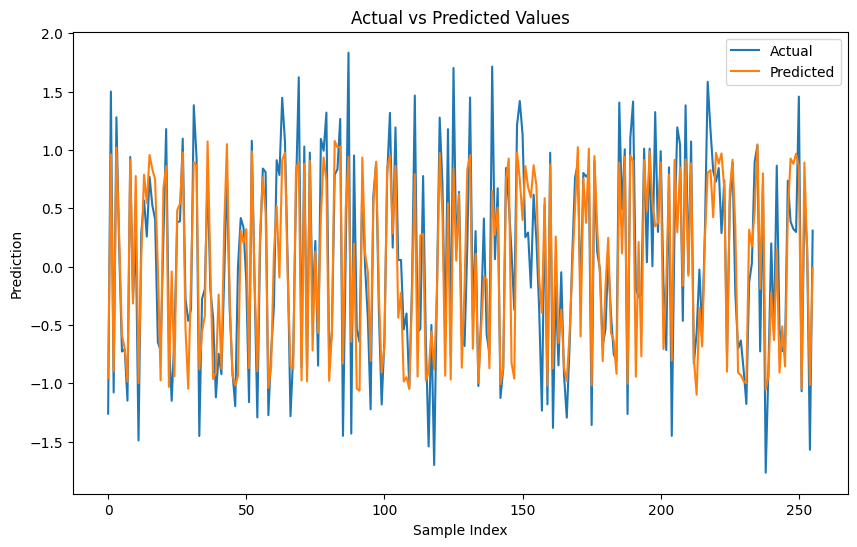

In [14]:

# Assuming 'test_dataset' is a tuple of (inputs, targets)
for batch in test_dataset.take(1):  # Take a single batch from the test dataset
    inputs, targets = batch

# Predict the output using the trained model
predicted = model.predict(inputs)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(targets.numpy().flatten(), label='Actual')
plt.plot(predicted.flatten(), label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.legend()
plt.show()


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset)

Epoch 1/50
17/17 [==============================] - 4s 74ms/step - loss: 0.4838 - mae: 0.5823 - val_loss: 0.3978 - val_mae: 0.5212
Epoch 2/50
17/17 [==============================] - 1s 41ms/step - loss: 0.3199 - mae: 0.4624 - val_loss: 0.2541 - val_mae: 0.4071
Epoch 3/50
17/17 [==============================] - 1s 35ms/step - loss: 0.2226 - mae: 0.3783 - val_loss: 0.1879 - val_mae: 0.3507
Epoch 4/50
17/17 [==============================] - 1s 69ms/step - loss: 0.1908 - mae: 0.3486 - val_loss: 0.1694 - val_mae: 0.3307
Epoch 5/50
17/17 [==============================] - 1s 35ms/step - loss: 0.1763 - mae: 0.3344 - val_loss: 0.1658 - val_mae: 0.3261
Epoch 6/50
17/17 [==============================] - 1s 33ms/step - loss: 0.1721 - mae: 0.3310 - val_loss: 0.1736 - val_mae: 0.3346
Epoch 7/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1714 - mae: 0.3306 - val_loss: 0.1657 - val_mae: 0.3264
Epoch 8/50
17/17 [==============================] - 1s 36ms/step - loss: 0.1701 - m

8/8 [==============================] - 1s 5ms/step


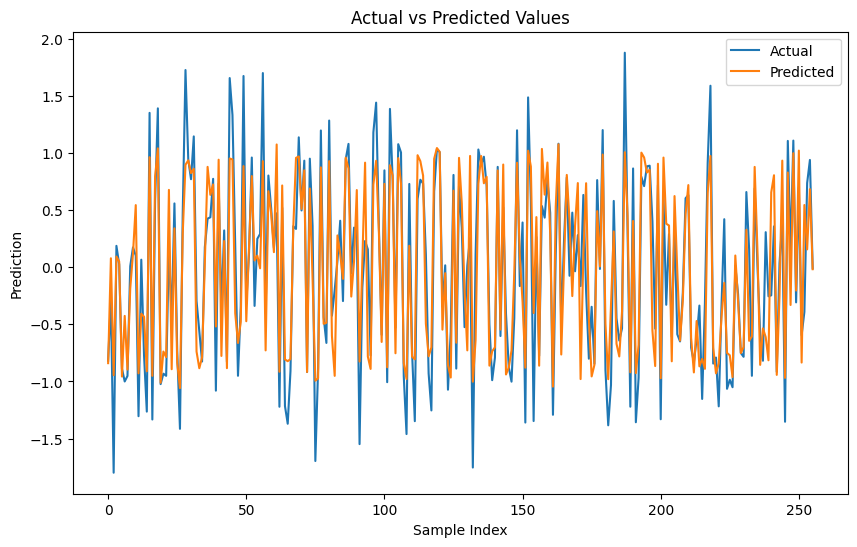

In [16]:

# Assuming 'val_dataset' is a tuple of (inputs, targets)
for batch in val_dataset.take(1):  # Take a single batch from the validation dataset
    inputs, targets = batch

# Predict the output using the trained model
predicted = model.predict(inputs)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(targets.numpy().flatten(), label='Actual')
plt.plot(predicted.flatten(), label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.legend()
plt.show()
